In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import re
import os
import random
import torch
print(torch.cuda.is_available(), torch.cuda.device_count())
print(os.getcwd())

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import catboost
from catboost import CatBoostRegressor

import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance as xgb_plot_importance

import lightgbm
from lightgbm import LGBMRegressor
from lightgbm import plot_importance as lgbm_plot_importance

print(f'CatBoost Version : {catboost.__version__}')
print(f'XGBoost Version  : {xgboost.__version__}')
print(f'LightGBM Version : {lightgbm.__version__}')

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings(action = 'ignore')

# Seed 고정
SEED = 42
def seed_everything(seed) :
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False) # True
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
seed_everything(SEED)

True 1
/data/ephemeral/Project
CatBoost Version : 1.2.2
XGBoost Version  : 2.0.2
LightGBM Version : 4.1.0


![data](./code/data/Data_Schema.png)

In [2]:
books = pd.read_csv('./code/data/books.csv')
users = pd.read_csv('./code/data/users.csv')
rating_train = pd.read_csv('./code/data/train_ratings.csv')
rating_test = pd.read_csv('./code/data/test_ratings.csv')
print(books.shape, users.shape, rating_train.shape, rating_test.shape)

(149570, 10) (68092, 3) (306795, 3) (76699, 3)


## `books`

In [3]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149569 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


### `isbn`
- https://sciencing.com/difference-isbn-13-isbn-10-5890031.html
- group identifier / publisher identifier / title identifier / and check digit로 구성
- Format : X-XXX-XXXXX-X

> **ISBN 확인**
- URL 정보를 사용해서 ISBN이 재대로 입력됐는지 확인

In [4]:
books['img_url_isbn'] = books['img_url'].apply(lambda x : x.split('/')[5].split('.')[0])
books[books['isbn'] != books['img_url_isbn']]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,img_url_isbn


In [5]:
books.drop(columns = 'img_url_isbn', inplace = True)

### `book_author` 결측치 확인
- 실제 저자가 없는 책
- 동일한 `book_title`의 데이터도 없음
- => 동일한 `publisher`의 최빈값으로 대체

In [6]:
books[books['book_title'] == books.loc[books['book_author'].isna(), 'book_title'].values[0]]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
73737,0751352497,A+ Quiz Masters:01 Earth,NaN,1999.0,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,NaN,NaN,NaN,images/0751352497.01.THUMBZZZ.jpg


In [7]:
books.loc[books['book_title'] == books.loc[books['book_author'].isna(), 'book_title'].values[0], 'book_author'] = \
    books.loc[books['publisher'] == books.loc[books['book_author'].isna(), 'publisher'].values[0], 'book_author'].mode().values[0]
print(books['book_author'].isna().sum())

0


### `year_of_publication`
- 10년 단위로 범주화

In [8]:
def preprocess_year(x) :
    if x < 1970 :
        return 1970
    elif (x >= 1970) and (x < 1980) :
        return 1980
    elif (x >= 1980) and (x < 1990) :
        return 1990
    elif (x >= 1990) and (x < 2000) :
        return 2000
    else :
        return 2010
    
books['years'] = books['year_of_publication'].apply(preprocess_year)
books['years'].value_counts()

years
2000    72358
2010    46301
1990    23809
1980     5636
1970     1466
Name: count, dtype: int64

### `publisher`
- `isbn`의 앞 4개의 숫자를 활용하여 `new_publisher` 생성

In [9]:
publisher_dict = (books['publisher'].value_counts()).to_dict()
publisher_count_df = pd.DataFrame(list(publisher_dict.items()), columns = ['publisher', 'count'])

publisher_count_df = publisher_count_df.sort_values(by = ['count'], ascending = False)
display(publisher_count_df.head(), books['publisher'].nunique())

,publisher,count
0,Harlequin,3005
1,Ballantine Books,2322
2,Pocket,2274
3,Penguin Books,1943
4,Bantam Books,1938


11571

In [10]:
modify_list = publisher_count_df[publisher_count_df['count'] > 1]['publisher'].values

for publisher in tqdm.tqdm(modify_list) :
    try :
        number = books[books['publisher'] == publisher]['isbn'].apply(lambda x : x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x : x[:4]) == number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x : x[:4]) == number].index, 'new_publisher'] = right_publisher
    except :
        pass
    
print(books['new_publisher'].nunique())

100%|██████████| 5276/5276 [07:42<00:00, 11.41it/s]

875


In [51]:
books['new_publisher'].value_counts()

new_publisher
Pocket                  7306
Harlequin               5268
Bantam Books            4816
St. Martin's Press      4043
Vintage Books USA       3822
                        ... 
Cornelsen Lernhilfen       1
Ecco (HarperCollins)       1
Verlag am Goetheanum       1
Janus                      1
Iceland Review             1
Name: count, Length: 1767, dtype: int64

### `language`, `category`, `summary`
- `language` & `category` & `summary`가 모두 결측인 행 -> 67227행
- `language` & `summary`만 결측인 행 -> 67227 + 1624행

In [11]:
display(books.loc[books['language'].isna(), ['language', 'category', 'summary']])
display(books.loc[books['language'].isna() & books['category'].notnull()])
display(books.loc[books['language'].isna() & books['summary'].notnull()])

,language,category,summary
5,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN
10,NaN,NaN,NaN
11,NaN,NaN,NaN
...,...,...,...
149560,NaN,NaN,NaN
149561,NaN,NaN,NaN
149564,NaN,NaN,NaN
149567,NaN,NaN,NaN


,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,years,new_publisher


,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,years,new_publisher


- `language`는 `isbn`의 region 정보를 활용하여 결측치 대체

In [12]:
region_code = set([code[:1] for code in books['isbn']])

region_lang = dict()

for code in region_code :
    lang = books.loc[books['isbn'].str.startswith(str(code)), 'language']
    mode = lang.mode()[0] if not code == 'B' else 'en' # 'B'로 시작하는 행들은 모두 NaN여서, 'en'으로 대체
    books.loc[(books['isbn'].str.startswith(str(code))) & (books['language'].isna()), 'language'] = mode

books['language'].isna().sum()

0

### `category`
- 상위 카테고리인 `category_high`를 생성

In [13]:
# 대괄호 삭제
books['category'] = books['category'].apply(lambda x : re.sub('[\W_]+',  ' ', str(x).lower()).strip())

category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category', 'count']
category_df.head()

,category,count
0,nan,68851
1,fiction,33016
2,juvenile fiction,5835
3,biography autobiography,3326
4,history,1927


In [14]:
books['category_high'] = books['category'].copy()

categories = ['garden', 'crafts', 'physics', 'adventure', 'music', 'fiction', 'nonfiction', 'science', 'science fiction', 'social', 'homicide', 
              'sociology', 'disease', 'religion', 'christian', 'philosophy', 'psycholog', 'mathemat', 'agricult', 'environmental',
              'business', 'poetry', 'drama', 'literary', 'travel', 'motion picture', 'children', 'cook', 'literature', 'electronic', 
              'humor', 'animal', 'bird', 'photograph', 'computer', 'house', 'ecology', 'family', 'architect', 'camp', 'criminal', 'language', 'india']

for category in categories :
    books.loc[books[books['category'].str.contains(category, na = False)].index, 'category_high'] = category

In [15]:
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category', 'count']
category_high_df.head(10)

,category,count
0,nan,68851
1,fiction,39678
2,biography autobiography,3326
3,history,1927
4,religion,1824
5,nonfiction,1427
6,humor,1291
7,social,1271
8,business,1146
9,cook,1125


In [16]:
# 5개 이하인 항목은 others
others_list = category_high_df[category_high_df['count'] < 5]['category'].values
print(len(others_list))

books.loc[books[books['category_high'].isin(others_list)].index, 'category_high'] = 'others'

2856


In [17]:
books['category_high'] = books['category_high'].replace('nan', np.nan)
books['category_high'] = books['category_high'].replace('unknown', np.nan)
print(books['category_high'].isna().sum())

books['category_high'].fillna('fiction', inplace = True)

68851


In [52]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             149570 non-null  object 
 7   category             149570 non-null  object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
 10  years                149570 non-null  int64  
 11  new_publisher        149570 non-null  object 
 12  category_high        149570 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 14.8+ MB


In [53]:
books.to_csv('./code/data/books_preprocessed.csv', index = False)

## `users`

In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
 3   city      68092 non-null  int64  
 4   state     68092 non-null  int64  
 5   country   68092 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 3.1+ MB


### `city`, `state`, `country` 전처리 방법 1 (성능 best)

In [18]:
users['location'] = users['location'].str.replace(r'[^a-zA-Z:,]', '', regex = True)

users['city'] = users['location'].apply(lambda x : x.split(',')[0].strip())
users['state'] = users['location'].apply(lambda x : x.split(',')[1].strip())
users['country'] = users['location'].apply(lambda x : x.split(',')[2].strip())

users = users.replace('na', np.nan)
users = users.replace('', np.nan)

users[['location', 'city', 'state', 'country']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  68092 non-null  object
 1   city      67963 non-null  object
 2   state     64838 non-null  object
 3   country   65968 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


In [19]:
# preprocess_loc.csv 전처리 방법
modify_location = users[(users['country'].isna())&(users['city'].notnull())]['city'].values
location = users[(users['location'].str.contains('seattle'))&(users['country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in tqdm.tqdm(modify_location):
    try:
        right_location = users[(users['location'].str.contains(location))&(users['country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

for location in tqdm.tqdm(location_list) :
    users.loc[users[users['city'] == location.split(',')[0]].index, 'state'] = location.split(',')[1]
    users.loc[users[users['city'] == location.split(',')[0]].index, 'country'] = location.split(',')[2]

city2idx = {v:k for k,v in enumerate(users['city'].unique())}
state2idx = {v:k for k,v in enumerate(users['state'].unique())}
country2idx = {v:k for k,v in enumerate(users['country'].unique())}

users['city'] = users['city'].map(city2idx)
users['state'] = users['state'].map(state2idx)
users['country'] = users['country'].map(country2idx)

  0%|          | 0/2113 [00:00<?, ?it/s]

100%|██████████| 1963/1963 [00:20<00:00, 97.56it/s] 


### `city`, `state`, `country` 전처리 방법 2 (성능이 더 안좋은 듯)
- `city`가 가장 결측치가 적지만, 고윳값이 많아서 모델링할 때 그닥 좋은 성능을 낼 것 같지 않아보임
    - `country`의 결측치를 채워서 분석에 사용하는 쪽으로 방향을 설정

In [22]:
print(users['city'].nunique(), users['state'].nunique(), users['country'].nunique())

11958 1499 316


In [23]:
# country가 결측 / city 결측 X인 경우
cities = users[(users['city'].notnull()) & (users['country'].isna())]['city'].values

for city in tqdm.tqdm(cities) :
    try :
        country = users.loc[(users['location'].str.contains(city)), 'country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(city)) & (users['country'].isna()), 'country'] = country
    except :
        pass
    
# country가 결측 / state 결측 X인 경우
states = users[(users['state'].notnull()) & (users['country'].isna())]['state'].values

for state in tqdm.tqdm(states) :
    try :
        country = users.loc[(users['location'].str.contains(state)), 'country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(state)) & (users['country'].isna()), 'country'] = country
    except :
        pass

# 각 나라 별로 location의 최빈값으로 대체
countries_list = users['country'].value_counts()
for country in tqdm.tqdm(countries_list.index) :
    try :
        new_country = users.loc[(users['location'].str.contains(country)), 'country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(country)) & (users['country'] == country), 
                  'country'] = new_country
    except :
        pass

  0%|          | 0/623 [00:00<?, ?it/s]

100%|██████████| 316/316 [00:16<00:00, 18.74it/s]


In [24]:
print(users['country'].unique())

['canada' nan 'usa' 'malaysia' 'newzealand' 'finland' 'unitedkingdom'
 'portugal' 'brazil' 'germany' 'austria' 'italy' 'australia' 'france'
 'costarica' 'netherlands' 'poland' 'iran' 'aruba' 'spain' 'taiwan'
 'singapore' 'argentina' 'romania' 'greece' 'ireland' 'belgium'
 'philippines' 'southafrica' 'switzerland' 'yugoslavia' 'turkey' 'japan'
 'china' 'qatar' 'sweden' 'kuwait' 'indonesia' 'nepal' 'unitedstates'
 'slovakia' 'norway' 'dominicanrepublic' 'southkorea' 'macedonia' 'kenya'
 'mauritius' 'madagascar' 'israel' 'egypt' 'denmark' 'guatemala'
 'euskalherria' 'palau' 'czechrepublic' 'venezuela' 'faraway' 'antarctica'
 'andorra' 'bulgaria' 'nigeria' 'everywhereandanywhere' 'slovenia' 'chile'
 'kcb' 'hongkong' 'luxembourg' 'iceland' 'honduras' 'zambia' 'zimbabwe'
 'phillipines' 'trinidadandtobago' 'belize' 'algeria' 'vanwert' 'bermuda'
 'bahamas' 'saudiarabia' 'cyprus' 'universe' 'albania' 'mozambique'
 'ukraine' 'pakistan' 'guinea' 'caymanislands' 'tdzimi' 'tonga' 'srilanka'
 'saint

- `country`의 오타나 오기입되어 있는 값 처리
- canada -> 'canada', 'cananda', 'vvh', 'lkjlj'
- italy -> 'italia', 'italy', 'litalia', 'ineurope'
- phillipines -> 'phillipines', 'phillippines'
- spain -> 'catalunyaspain', 'spain'
- unitedkingdom -> 'unitedkingdom', 'usacurrentlylivinginengland', 'unitedkindgonm', 'obviously'
- usa -> 'unitedstates', 'unitedstaes', 'unitedstatesofamerica', 'usa', 'usanow', 'ysa', 'csa', 'anystate', 'usacanada'
- uruguay -> 'urugua', 'uruguay'

In [25]:
print(f'Before : {users["country"].nunique()}')
country_mapping = {
    'canada': ['canada', 'cananda', 'vvh', 'lkjlj'],
    'italy': ['italia', 'italy', 'litalia', 'ineurope'],
    'phillipines': ['phillipines', 'phillippines'],
    'spain': ['catalunyaspain', 'spain'],
    'unitedkingdom': ['unitedkingdom', 'usacurrentlylivinginengland', 'unitedkindgonm', 'obviously'],
    'usa': ['unitedstates', 'unitedstaes', 'unitedsates', 'unitedstatesofamerica', 'usa', 'usanow', 'ysa', 'csa', 'anystate', 'usacanada'],
    'uruguay': ['urugua', 'uruguay']
}

for target_country, aliases in country_mapping.items() :
    users['country'].replace(aliases, target_country, inplace = True)

print(f'After : {users["country"].nunique()}')

Before : 184
After : 166


In [26]:
print(users['country'].isna().sum())
users['country'].value_counts().to_frame()

94


,count
country,
usa,45756
canada,6490
germany,3591
unitedkingdom,3026
australia,1834
...,...
labelgique,1
lafrance,1
gabon,1


In [27]:
# 10개 이하의 country를 others로 변환
others = users['country'].value_counts()[users['country'].value_counts() < 10].index
for country in tqdm.tqdm(others) :
    try :
        users.loc[(users['country'] == country), 'country'] = 'others'
    except :
        pass

100%|██████████| 118/118 [00:00<00:00, 226.39it/s]


In [28]:
# 나머지 결측치에 대해서도 others로 변환
users['country'] = users['country'].fillna('others')
print(users['country'].nunique())

49


### `age`
- 국가별 `age`의 중앙값으로 대체
- 국가별 `age`의 중앙값이 존재하지 않는 경우, 전체 `age`의 중앙값으로 대체

In [20]:
country_age_median = users.groupby('country')['age'].median()
users['age'] = users.apply(lambda x : country_age_median[x['country']] if pd.isna(x['age']) else x['age'], axis = 1)

global_age_median = users['age'].median()
users['age'].fillna(global_age_median, inplace = True)
print(users['age'].isna().sum())

0


- 10살 단위 연령대로 분할하여 `new_age` 변수 생성

In [21]:
users['new_age'] = ((users['age'] // 10) * 10).astype(int)
users[['age', 'new_age']]

,age,new_age
0,33.0,30
1,49.0,40
2,35.0,30
3,30.0,30
4,36.0,30
...,...,...
68087,54.0,50
68088,74.0,70
68089,36.0,30
68090,33.0,30


In [22]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       68092 non-null  float64
 3   city      68092 non-null  int64  
 4   state     68092 non-null  int64  
 5   country   68092 non-null  int64  
 6   new_age   68092 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 3.6+ MB


In [23]:
users.to_csv('./code/data/users_preprocessed.csv', index = False)

## `ratings`와 Merge

In [7]:
path = './code/data/'
books_pre = pd.read_csv(path + 'books_preprocessed.csv')
users_pre = pd.read_csv(path + 'users_preprocessed.csv')
train_ratings = pd.read_csv(path + 'train_ratings.csv')
test_ratings = pd.read_csv(path + 'test_ratings.csv')

print(books_pre.shape, users_pre.shape, train_ratings.shape, test_ratings.shape)

(149570, 13) (68092, 7) (306795, 3) (76699, 3)


In [8]:
display(books_pre.info(), users_pre.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             149570 non-null  object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
 10  years                149570 non-null  int64  
 11  new_publisher        149570 non-null  object 
 12  category_high        149570 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 14.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entr

None

None

In [9]:
books_final = books_pre[['isbn', 'book_title', 'book_author', 'language', 'years', 'new_publisher', 'category_high']]
users_final = users_pre[['user_id', 'city', 'state', 'country', 'new_age']] # [['user_id', 'country', 'new_age']]

In [10]:
train_ratings['index'] = train_ratings.index
train_df = pd.merge(books_final, train_ratings, how = 'left', on = 'isbn').dropna(subset = 'rating')
train_df = pd.merge(users_final, train_df, how = 'left', on = 'user_id').dropna(subset = 'rating')
train_df = train_df.sort_values('index').reset_index(drop = True).drop(columns = 'index')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        306795 non-null  int64  
 1   city           306795 non-null  int64  
 2   state          306795 non-null  int64  
 3   country        306795 non-null  int64  
 4   new_age        306795 non-null  int64  
 5   isbn           306795 non-null  object 
 6   book_title     306795 non-null  object 
 7   book_author    306795 non-null  object 
 8   language       306795 non-null  object 
 9   years          306795 non-null  float64
 10  new_publisher  306795 non-null  object 
 11  category_high  306795 non-null  object 
 12  rating         306795 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 30.4+ MB


In [11]:
test_ratings['index'] = test_ratings.index
test_df = pd.merge(books_final, test_ratings, how = 'left', on = 'isbn').dropna(subset = 'rating')
test_df = pd.merge(users_final, test_df, how = 'left', on = 'user_id').dropna(subset = 'rating')
test_df = test_df.sort_values('index').reset_index(drop = True).drop(columns = 'index')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76699 entries, 0 to 76698
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        76699 non-null  int64  
 1   city           76699 non-null  int64  
 2   state          76699 non-null  int64  
 3   country        76699 non-null  int64  
 4   new_age        76699 non-null  int64  
 5   isbn           76699 non-null  object 
 6   book_title     76699 non-null  object 
 7   book_author    76699 non-null  object 
 8   language       76699 non-null  object 
 9   years          76699 non-null  float64
 10  new_publisher  76699 non-null  object 
 11  category_high  76699 non-null  object 
 12  rating         76699 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 7.6+ MB


- `avg_rating`
    - `user_id`별 평균 `rating`의 값을 계산

In [12]:
rating_avg = train_df.groupby('user_id', as_index = False)['rating'].mean().rename({'rating' : 'rating_avg'}, axis = 1)
train_df = pd.merge(train_df, rating_avg, how = 'left', on = 'user_id')
test_df = pd.merge(test_df, rating_avg, how = 'left', on = 'user_id')
test_df['rating_avg'].fillna(train_df['rating'].mean(), inplace = True)

In [13]:
train_df['user_id'] = train_df['user_id'].astype('str')
train_df['city'] = train_df['city'].astype('str')
train_df['state'] = train_df['state'].astype('str')
train_df['country'] = train_df['country'].astype('str')
train_df['new_age'] = train_df['new_age'].astype('str')
train_df['years'] = train_df['years'].astype('int').astype('str')
train_df['rating'] = train_df['rating'].astype('int')

test_df['user_id'] = test_df['user_id'].astype('str')
test_df['city'] = test_df['city'].astype('str')
test_df['state'] = test_df['state'].astype('str')
test_df['country'] = test_df['country'].astype('str')
test_df['new_age'] = test_df['new_age'].astype('str')
test_df['years'] = test_df['years'].astype('int').astype('str')
test_df['rating'] = test_df['rating'].astype('int')

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        306795 non-null  object 
 1   city           306795 non-null  object 
 2   state          306795 non-null  object 
 3   country        306795 non-null  object 
 4   new_age        306795 non-null  object 
 5   isbn           306795 non-null  object 
 6   book_title     306795 non-null  object 
 7   book_author    306795 non-null  object 
 8   language       306795 non-null  object 
 9   years          306795 non-null  object 
 10  new_publisher  306795 non-null  object 
 11  category_high  306795 non-null  object 
 12  rating         306795 non-null  int64  
 13  rating_avg     306795 non-null  float64
dtypes: float64(1), int64(1), object(12)
memory usage: 32.8+ MB


# Model


- `Catboost` 학습용 데이터

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df.drop(columns = 'rating'), train_df['rating'],
                                                      test_size = 0.1, random_state = SEED)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(276115, 13) (276115,) (30680, 13) (30680,)


- `LightGBM`, `XGBoost` 학습용 데이터
    - `object`형이 들어가면 안되므로 LabelEncoding

In [15]:
train_GB = train_df.copy()
test_GB = test_df.copy()

In [16]:
cat_col = ['isbn', 'book_title', 'book_author', 'language', 'new_publisher', 'category_high']
num_col = ['user_id', 'new_age', 'years', 'city', 'state', 'country']

for col in cat_col :
    le = LabelEncoder()
    train_GB[col] = le.fit_transform(train_GB[col])
    for label in tqdm.tqdm((test_GB[col].unique())) :
        if label not in le.classes_ : 
            le.classes_ = np.append(le.classes_, label)
    test_GB[col] = le.transform(test_GB[col])

for col in num_col :
    train_GB[col] = train_GB[col].astype(int)
    test_GB[col] = test_GB[col].astype(int)

100%|██████████| 391/391 [00:00<00:00, 68973.08it/s]


In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(train_GB.drop(columns = 'rating'), train_GB['rating'],
                                                      test_size = 0.1, random_state = SEED)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(276115, 13) (276115,) (30680, 13) (30680,)


## Catboost

In [41]:
from optuna.integration import CatBoostPruningCallback

def objectiveCAT(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.1, 0.5]),
        'depth' : trial.suggest_int('depth', 1, 15),
        'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel', [1e-3, 0.01, 0.1, 0.5]),   
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    }

    if param['bootstrap_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli':
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
        
    model = CatBoostRegressor(**param, iterations = 5000, loss_function = 'RMSE', eval_metric = 'RMSE',
                              use_best_model = True, random_state = SEED, # task_type = 'GPU', devices = '0'
                              cat_features = [i for i in range(0, 12)])
    pruning_callback = CatBoostPruningCallback(trial, 'RMSE', eval_set_index = 1)
    cat_model = model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = 500,
                          early_stopping_rounds = 100, callbacks = [pruning_callback])
    pruning_callback.check_pruned()
    
    score = mean_squared_error(y_valid, cat_model.predict(X_valid), squared = False)
    return score

In [37]:
def objectiveCAT_GPU(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'depth' : trial.suggest_int('depth', 1, 15),
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-5, 1e-3, 0.1, 0.5]),
        'l2_leaf_reg' : trial.suggest_categorical('l2_leaf_reg', [1e-3, 1, 3, 5]),
        'random_strength' : trial.suggest_categorical('random_strength', [1e-5, 1e-3, 0.1, 1]),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 1, 10),
        'leaf_estimation_iterations' : trial.suggest_int('leaf_estimation_iterations', 1, 15),
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    }
    
    if param['bootstrap_type'] == 'Bayesian' :
        param['bagging_temperature'] = trial.suggest_int('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli' :
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
    
    model = CatBoostRegressor(**param, iterations = 1000,
                              loss_function = 'RMSE', eval_metric = 'RMSE',
                              use_best_model = True, random_state = SEED,
                              task_type = 'GPU', devices = '0',
                              cat_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cat_model = model.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], # CatBoostError: Multiple eval sets are not supported on GPU
                          verbose = 500, early_stopping_rounds = 100)
    
    score = mean_squared_error(y_valid, cat_model.predict(X_valid), squared = False)
    return score

In [42]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objectiveCAT(trial, X_train, y_train, X_valid, y_valid), n_trials = 50)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n') 

[I 2023-12-15 09:18:37,458] A new study created in memory with name: no-name-fab9994b-8e71-4096-8c8e-52d7a1827570


0:	learn: 2.4268021	test: 2.4267926	test1: 2.4289534	best: 2.4289534 (0)	total: 61.9ms	remaining: 5m 9s
500:	learn: 2.0049017	test: 1.8532447	test1: 2.0005135	best: 2.0005135 (500)	total: 19.8s	remaining: 2m 57s
1000:	learn: 1.9168741	test: 1.7401416	test1: 1.9174239	best: 1.9174239 (1000)	total: 39.2s	remaining: 2m 36s
1500:	learn: 1.8779562	test: 1.6914820	test1: 1.8798658	best: 1.8798658 (1500)	total: 58.3s	remaining: 2m 15s
2000:	learn: 1.8556781	test: 1.6630487	test1: 1.8572525	best: 1.8572525 (1998)	total: 1m 17s	remaining: 1m 56s
2500:	learn: 1.8423977	test: 1.6437202	test1: 1.8427748	best: 1.8427748 (2500)	total: 1m 38s	remaining: 1m 38s
3000:	learn: 1.8336952	test: 1.6312449	test1: 1.8328209	best: 1.8328209 (3000)	total: 1m 58s	remaining: 1m 19s
3500:	learn: 1.8286893	test: 1.6244503	test1: 1.8264614	best: 1.8264614 (3500)	total: 2m 19s	remaining: 59.6s
4000:	learn: 1.8252648	test: 1.6158669	test1: 1.8216740	best: 1.8216740 (4000)	total: 2m 38s	remaining: 39.6s
4500:	learn: 1.

[I 2023-12-15 09:22:44,831] Trial 0 finished with value: 1.8150551708876415 and parameters: {'learning_rate': 0.01, 'depth': 3, 'colsample_bylevel': 0.1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.8182496720710062}. Best is trial 0 with value: 1.8150551708876415.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 13.5ms	remaining: 1m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.400082769
bestIteration = 395

Shrink model to first 396 iterations.


[I 2023-12-15 09:22:51,530] Trial 1 finished with value: 2.4000827691932023 and parameters: {'learning_rate': 0.1, 'depth': 5, 'colsample_bylevel': 0.001, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 1.8150551708876415.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 16.6ms	remaining: 1m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.434994074
bestIteration = 84

Shrink model to first 85 iterations.


[I 2023-12-15 09:22:55,938] Trial 2 finished with value: 2.434994073695323 and parameters: {'learning_rate': 0.01, 'depth': 15, 'colsample_bylevel': 0.001, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9183883618709039}. Best is trial 0 with value: 1.8150551708876415.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 16.7ms	remaining: 1m 23s
500:	learn: 2.3855774	test: 2.3593852	test1: 2.3834089	best: 2.3834089 (500)	total: 4.78s	remaining: 42.9s
1000:	learn: 2.3303361	test: 2.2829149	test1: 2.3259085	best: 2.3259085 (1000)	total: 9.35s	remaining: 37.3s
1500:	learn: 2.3010250	test: 2.2384464	test1: 2.2951706	best: 2.2951706 (1500)	total: 13.9s	remaining: 32.5s
2000:	learn: 2.2716439	test: 2.2015185	test1: 2.2652632	best: 2.2652632 (2000)	total: 18.5s	remaining: 27.7s
2500:	learn: 2.2444716	test: 2.1597715	test1: 2.2365068	best: 2.2365068 (2500)	total: 22.8s	remaining: 22.8s
3000:	learn: 2.1974401	test: 2.1020745	test1: 2.1894233	best: 2.1894233 (3000)	total: 27.3s	remaining: 18.2s
3500:	learn: 2.1714535	test: 2.0671967	test1: 2.1628908	best: 2.1628908 (3500)	total: 32.5s	remaining: 13.9s
4000:	learn: 2.1527364	test: 2.0403941	test1: 2.1430196	best: 2.1430196 (4000)	total: 37.6s	remaining: 9.39s
4500:	learn: 2.1236061	te

[I 2023-12-15 09:24:31,113] Trial 3 finished with value: 2.094746611142796 and parameters: {'learning_rate': 0.01, 'depth': 9, 'colsample_bylevel': 0.01, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.45227288910538066}. Best is trial 0 with value: 1.8150551708876415.


0:	learn: 2.1284396	test: 2.1281082	test1: 2.1324790	best: 2.1324790 (0)	total: 252ms	remaining: 20m 59s
500:	learn: 1.7743201	test: 1.7663947	test1: 1.8191665	best: 1.8191148 (435)	total: 1m 52s	remaining: 16m 49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.818646592
bestIteration = 539

Shrink model to first 540 iterations.


[I 2023-12-15 09:26:58,443] Trial 4 finished with value: 1.8186465915967613 and parameters: {'learning_rate': 0.5, 'depth': 6, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.154614284548341}. Best is trial 0 with value: 1.8150551708876415.
[I 2023-12-15 09:27:01,169] Trial 5 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 10.4ms	remaining: 52s

bestTest = 2.435036412
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-15 09:27:03,893] Trial 6 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 10.8ms	remaining: 54.2s

bestTest = 2.435036413
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.4322343	test: 2.4322342	test1: 2.4342651	best: 2.4342651 (0)	total: 142ms	remaining: 11m 47s

bestTest = 2.321849363
bestIteration = 185

Shrink model to first 186 iterations.


[I 2023-12-15 09:27:33,318] Trial 7 pruned. Trial was pruned at iteration 185.


0:	learn: 2.3595712	test: 2.3595712	test1: 2.3627048	best: 2.3627048 (0)	total: 51.2ms	remaining: 4m 16s
500:	learn: 1.8176844	test: 1.6259661	test1: 1.8065721	best: 1.8065527 (494)	total: 20s	remaining: 2m 59s
1000:	learn: 1.8130855	test: 1.5849848	test1: 1.7990449	best: 1.7990449 (1000)	total: 39.7s	remaining: 2m 38s
1500:	learn: 1.8109271	test: 1.5721710	test1: 1.7960285	best: 1.7960187 (1497)	total: 59.3s	remaining: 2m 18s
2000:	learn: 1.8092761	test: 1.5631635	test1: 1.7936240	best: 1.7936227 (1998)	total: 1m 19s	remaining: 1m 59s
2500:	learn: 1.8079935	test: 1.5537499	test1: 1.7918029	best: 1.7918021 (2495)	total: 1m 39s	remaining: 1m 39s
3000:	learn: 1.8068671	test: 1.5471587	test1: 1.7903687	best: 1.7903686 (2999)	total: 1m 58s	remaining: 1m 18s
3500:	learn: 1.8057812	test: 1.5451196	test1: 1.7891958	best: 1.7891921 (3493)	total: 2m 18s	remaining: 59.3s
4000:	learn: 1.8048975	test: 1.5431054	test1: 1.7881584	best: 1.7881479 (3990)	total: 2m 38s	remaining: 39.6s
4500:	learn: 1.8

[I 2023-12-15 09:31:48,811] Trial 8 finished with value: 1.7869959459545286 and parameters: {'learning_rate': 0.1, 'depth': 2, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.3761517140362796}. Best is trial 8 with value: 1.7869959459545286.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 13.6ms	remaining: 1m 7s

bestTest = 2.435036412
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-15 09:31:51,493] Trial 9 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3735821	test: 2.3735821	test1: 2.3767712	best: 2.3767712 (0)	total: 21.9ms	remaining: 1m 49s
500:	learn: 1.8343926	test: 1.8025933	test1: 1.8359859	best: 1.8359859 (500)	total: 4.85s	remaining: 43.5s
1000:	learn: 1.8327487	test: 1.8049763	test1: 1.8328708	best: 1.8328641 (997)	total: 9.48s	remaining: 37.9s
1500:	learn: 1.8321001	test: 1.8064333	test1: 1.8316307	best: 1.8316291 (1498)	total: 14.2s	remaining: 33s
2000:	learn: 1.8316883	test: 1.8071236	test1: 1.8308722	best: 1.8308722 (2000)	total: 18.8s	remaining: 28.2s
2500:	learn: 1.8313919	test: 1.8073588	test1: 1.8304367	best: 1.8304361 (2496)	total: 23.5s	remaining: 23.5s
3000:	learn: 1.8311722	test: 1.8072662	test1: 1.8300242	best: 1.8300242 (3000)	total: 28.5s	remaining: 19s

bestTest = 1.829944758
bestIteration = 3194

Shrink model to first 3195 iterations.


[I 2023-12-15 09:32:44,907] Trial 10 pruned. Trial was pruned at iteration 3198.
[I 2023-12-15 09:32:47,594] Trial 11 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4329936	test: 2.4329933	test1: 2.4350244	best: 2.4350244 (0)	total: 25.4ms	remaining: 2m 6s

bestTest = 2.435024399
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.4268141	test: 2.4268023	test1: 2.4289519	best: 2.4289519 (0)	total: 64.6ms	remaining: 5m 22s

bestTest = 2.16916112
bestIteration = 185

Shrink model to first 186 iterations.


[I 2023-12-15 09:32:57,236] Trial 12 pruned. Trial was pruned at iteration 185.


0:	learn: 2.3570862	test: 2.3568528	test1: 2.3596714	best: 2.3596714 (0)	total: 372ms	remaining: 31m
500:	learn: 1.4819682	test: 1.5861359	test1: 1.8085451	best: 1.8083916 (497)	total: 2m 37s	remaining: 23m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.808391623
bestIteration = 497

Shrink model to first 498 iterations.


[I 2023-12-15 09:36:08,367] Trial 13 finished with value: 1.8083916234429878 and parameters: {'learning_rate': 0.1, 'depth': 13, 'colsample_bylevel': 0.1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.1771336775041785}. Best is trial 8 with value: 1.7869959459545286.


0:	learn: 2.3405156	test: 2.3403435	test1: 2.3434893	best: 2.3434893 (0)	total: 712ms	remaining: 59m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.821530358
bestIteration = 223

Shrink model to first 224 iterations.


[I 2023-12-15 09:40:11,950] Trial 14 finished with value: 1.821530357540358 and parameters: {'learning_rate': 0.1, 'depth': 13, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.893376103380813}. Best is trial 8 with value: 1.7869959459545286.


0:	learn: 2.3568118	test: 2.3563069	test1: 2.3591183	best: 2.3591183 (0)	total: 302ms	remaining: 25m 10s
500:	learn: 1.6804495	test: 1.5987295	test1: 1.8007099	best: 1.8007099 (500)	total: 1m 52s	remaining: 16m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.796118925
bestIteration = 896

Shrink model to first 897 iterations.


[I 2023-12-15 09:44:04,379] Trial 15 finished with value: 1.796118925160058 and parameters: {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.475439486695015}. Best is trial 8 with value: 1.7869959459545286.


0:	learn: 2.3421169	test: 2.3420576	test1: 2.3448698	best: 2.3448698 (0)	total: 575ms	remaining: 47m 55s
500:	learn: 1.6859214	test: 1.4879397	test1: 1.7740359	best: 1.7736739 (477)	total: 4m 47s	remaining: 42m 59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.773641388
bestIteration = 512

Shrink model to first 513 iterations.


[I 2023-12-15 09:50:02,786] Trial 16 finished with value: 1.7736413877726087 and parameters: {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 1.7736413877726087.


0:	learn: 2.3421169	test: 2.3420576	test1: 2.3448698	best: 2.3448698 (0)	total: 538ms	remaining: 44m 47s
500:	learn: 1.6859214	test: 1.4879397	test1: 1.7740359	best: 1.7736739 (477)	total: 4m 48s	remaining: 43m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.773641388
bestIteration = 512

Shrink model to first 513 iterations.


[I 2023-12-15 09:56:03,079] Trial 17 finished with value: 1.7736413877726087 and parameters: {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 1.7736413877726087.


0:	learn: 2.3421169	test: 2.3420576	test1: 2.3448698	best: 2.3448698 (0)	total: 509ms	remaining: 42m 23s
500:	learn: 1.6859214	test: 1.4879397	test1: 1.7740359	best: 1.7736739 (477)	total: 4m 47s	remaining: 43m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.773641388
bestIteration = 512

Shrink model to first 513 iterations.


[I 2023-12-15 10:02:02,860] Trial 18 finished with value: 1.7736413877726087 and parameters: {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 1.7736413877726087.


0:	learn: 2.0508001	test: 2.0505532	test1: 2.0568831	best: 2.0568831 (0)	total: 537ms	remaining: 44m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.790193749
bestIteration = 41

Shrink model to first 42 iterations.


[I 2023-12-15 10:03:25,073] Trial 19 finished with value: 1.7901937485708732 and parameters: {'learning_rate': 0.5, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 1.7736413877726087.
[I 2023-12-15 10:03:28,052] Trial 20 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4321221	test: 2.4321216	test1: 2.4341560	best: 2.4341560 (0)	total: 351ms	remaining: 29m 17s

bestTest = 2.434156003
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3421169	test: 2.3420576	test1: 2.3448698	best: 2.3448698 (0)	total: 544ms	remaining: 45m 20s
500:	learn: 1.6859214	test: 1.4879397	test1: 1.7740359	best: 1.7736739 (477)	total: 4m 46s	remaining: 42m 56s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.773641388
bestIteration = 512

Shrink model to first 513 iterations.


[I 2023-12-15 10:09:26,254] Trial 21 finished with value: 1.7736413877726087 and parameters: {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 1.7736413877726087.


0:	learn: 2.3394753	test: 2.3394120	test1: 2.3425761	best: 2.3425761 (0)	total: 677ms	remaining: 56m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.780126668
bestIteration = 238

Shrink model to first 239 iterations.


[I 2023-12-15 10:13:41,257] Trial 22 finished with value: 1.7801266678897376 and parameters: {'learning_rate': 0.1, 'depth': 13, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 1.7736413877726087.


0:	learn: 2.3449499	test: 2.3448904	test1: 2.3478343	best: 2.3478343 (0)	total: 463ms	remaining: 38m 34s

bestTest = 2.347834308
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-15 10:13:44,382] Trial 23 pruned. Trial was pruned at iteration 0.
[I 2023-12-15 10:13:47,017] Trial 24 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 9.88ms	remaining: 49.4s

bestTest = 2.435036412
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3394809	test: 2.3394206	test1: 2.3425893	best: 2.3425893 (0)	total: 988ms	remaining: 1h 22m 19s

bestTest = 2.080136891
bestIteration = 5

Shrink model to first 6 iterations.


[I 2023-12-15 10:13:53,552] Trial 25 pruned. Trial was pruned at iteration 5.
[I 2023-12-15 10:13:56,535] Trial 26 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3471180	test: 2.3470701	test1: 2.3499087	best: 2.3499087 (0)	total: 314ms	remaining: 26m 10s

bestTest = 2.349908729
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3449499	test: 2.3448904	test1: 2.3478343	best: 2.3478343 (0)	total: 481ms	remaining: 40m 4s

bestTest = 2.347834308
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-15 10:13:59,727] Trial 27 pruned. Trial was pruned at iteration 0.


0:	learn: 2.0387944	test: 2.0385372	test1: 2.0465387	best: 2.0465387 (0)	total: 815ms	remaining: 1h 7m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.797826799
bestIteration = 14

Shrink model to first 15 iterations.


[I 2023-12-15 10:15:41,796] Trial 28 finished with value: 1.797826798858883 and parameters: {'learning_rate': 0.5, 'depth': 14, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 1.7736413877726087.
[I 2023-12-15 10:15:44,531] Trial 29 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 9.95ms	remaining: 49.7s

bestTest = 2.435036412
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3449380	test: 2.3448927	test1: 2.3478332	best: 2.3478332 (0)	total: 418ms	remaining: 34m 52s

bestTest = 2.347833152
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-15 10:15:47,616] Trial 30 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3421169	test: 2.3420576	test1: 2.3448698	best: 2.3448698 (0)	total: 536ms	remaining: 44m 37s
500:	learn: 1.6859214	test: 1.4879397	test1: 1.7740359	best: 1.7736739 (477)	total: 4m 46s	remaining: 42m 49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.773641388
bestIteration = 512

Shrink model to first 513 iterations.


[I 2023-12-15 10:21:45,147] Trial 31 finished with value: 1.7736413877726087 and parameters: {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 1.7736413877726087.


0:	learn: 2.3405485	test: 2.3404822	test1: 2.3436484	best: 2.3436484 (0)	total: 595ms	remaining: 49m 32s


[I 2023-12-15 10:21:49,204] Trial 32 pruned. Trial was pruned at iteration 2.



bestTest = 2.218707357
bestIteration = 2

Shrink model to first 3 iterations.
0:	learn: 2.3449499	test: 2.3448904	test1: 2.3478343	best: 2.3478343 (0)	total: 468ms	remaining: 39m 1s

bestTest = 2.347834308
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-15 10:21:52,311] Trial 33 pruned. Trial was pruned at iteration 0.
[I 2023-12-15 10:21:55,058] Trial 34 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 10.9ms	remaining: 54.4s

bestTest = 2.435036412
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-15 10:21:58,277] Trial 35 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4241672	test: 2.4241656	test1: 2.4262687	best: 2.4262687 (0)	total: 499ms	remaining: 41m 33s

bestTest = 2.426268693
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3427469	test: 2.3481433	test1: 2.3475373	best: 2.3475373 (0)	total: 473ms	remaining: 39m 25s

bestTest = 2.3475373
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-15 10:22:01,442] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2023-12-15 10:22:04,146] Trial 37 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 11ms	remaining: 55.2s

bestTest = 2.435036412
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-15 10:22:06,762] Trial 38 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 10.1ms	remaining: 50.3s

bestTest = 2.435036413
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-15 10:22:09,690] Trial 39 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4012213	test: 2.3825582	test1: 2.3972509	best: 2.3972509 (0)	total: 273ms	remaining: 22m 43s

bestTest = 2.397250865
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.4233835	test: 2.4233771	test1: 2.4255161	best: 2.4255161 (0)	total: 810ms	remaining: 1h 7m 27s

bestTest = 2.425516088
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-15 10:22:13,138] Trial 40 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3421169	test: 2.3420576	test1: 2.3448698	best: 2.3448698 (0)	total: 532ms	remaining: 44m 21s
500:	learn: 1.6859214	test: 1.4879397	test1: 1.7740359	best: 1.7736739 (477)	total: 4m 46s	remaining: 42m 51s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.773641388
bestIteration = 512

Shrink model to first 513 iterations.


[I 2023-12-15 10:28:11,193] Trial 41 finished with value: 1.7736413877726087 and parameters: {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 1.7736413877726087.


0:	learn: 2.3405485	test: 2.3404822	test1: 2.3436484	best: 2.3436484 (0)	total: 582ms	remaining: 48m 27s

bestTest = 2.218707357
bestIteration = 2

Shrink model to first 3 iterations.


[I 2023-12-15 10:28:15,231] Trial 42 pruned. Trial was pruned at iteration 2.


0:	learn: 2.3421169	test: 2.3420576	test1: 2.3448698	best: 2.3448698 (0)	total: 516ms	remaining: 42m 59s
500:	learn: 1.6859214	test: 1.4879397	test1: 1.7740359	best: 1.7736739 (477)	total: 4m 46s	remaining: 42m 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.773641388
bestIteration = 512

Shrink model to first 513 iterations.


[I 2023-12-15 10:34:13,270] Trial 43 finished with value: 1.7736413877726087 and parameters: {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 1.7736413877726087.
[I 2023-12-15 10:34:16,346] Trial 44 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4321000	test: 2.4320995	test1: 2.4341349	best: 2.4341349 (0)	total: 410ms	remaining: 34m 8s

bestTest = 2.434134881
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 14.8ms	remaining: 1m 14s

bestTest = 2.435036412
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-15 10:34:19,036] Trial 45 pruned. Trial was pruned at iteration 0.
[I 2023-12-15 10:34:22,101] Trial 46 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3471737	test: 2.3470764	test1: 2.3502109	best: 2.3502109 (0)	total: 362ms	remaining: 30m 10s

bestTest = 2.350210933
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3405485	test: 2.3404822	test1: 2.3436484	best: 2.3436484 (0)	total: 583ms	remaining: 48m 35s

bestTest = 2.218707357
bestIteration = 2

Shrink model to first 3 iterations.


[I 2023-12-15 10:34:26,222] Trial 47 pruned. Trial was pruned at iteration 2.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 10.1ms	remaining: 50.5s

bestTest = 2.435036413
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-15 10:34:28,961] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2023-12-15 10:34:31,993] Trial 49 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4296832	test: 2.4278047	test1: 2.4310837	best: 2.4310837 (0)	total: 304ms	remaining: 25m 21s

bestTest = 2.4310837
bestIteration = 0

Shrink model to first 1 iterations.
Best trial : score 1.7736413877726087, 
 params = {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'} 



In [46]:
X_data, y_data = train_df.drop(columns = 'rating'), train_df['rating']

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
valid_rmse = []
pred_df = pd.DataFrame()

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) : 
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    # Best Parameter 학습
    param = study.best_params
    
    cat_reg = CatBoostRegressor(**param, iterations = 5000, 
                                loss_function = 'RMSE', eval_metric = 'RMSE', 
                                use_best_model = True, random_state = SEED,
                                cat_features = [i for i in range(0, 12)])
    cat_reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
                verbose = 500, early_stopping_rounds = 100)
    
    # 모델 RMSE 출력
    score = mean_squared_error(y_valid, cat_reg.predict(X_valid), squared = False)
    valid_rmse.append(score)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {score:.5f}')
    
    # Predict
    pred = cat_reg.predict(test_df.drop(['rating'], axis = 1))
    pred_df[f'pred_{fold}'] = pred
    
print(f'CatBoost RMSE 평균 : {np.array(valid_rmse).mean():.5f} \n')

  0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 2.3586828	test: 2.3586828	test1: 2.3587182	best: 2.3587182 (0)	total: 198ms	remaining: 3m 17s
500:	learn: 1.6878775	test: 1.4848305	test1: 1.7671428	best: 1.7669015 (418)	total: 4m 46s	remaining: 4m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.766901543
bestIteration = 418

Shrink model to first 419 iterations.
Valid Set 1 번째 Fold RMSE : 1.76690


 10%|█         | 1/10 [05:00<45:08, 300.90s/it]

0:	learn: 2.3476359	test: 2.3475857	test1: 2.3466629	best: 2.3466629 (0)	total: 511ms	remaining: 8m 30s
500:	learn: 1.6876330	test: 1.4841290	test1: 1.7589785	best: 1.7587917 (433)	total: 4m 46s	remaining: 4m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.758677779
bestIteration = 543

Shrink model to first 544 iterations.
Valid Set 2 번째 Fold RMSE : 1.75868


 20%|██        | 2/10 [11:15<45:54, 344.34s/it]

0:	learn: 2.3476093	test: 2.3475319	test1: 2.3464069	best: 2.3464069 (0)	total: 509ms	remaining: 8m 28s
500:	learn: 1.6823380	test: 1.4807042	test1: 1.7508953	best: 1.7508565 (485)	total: 4m 50s	remaining: 4m 49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.750334967
bestIteration = 546

Shrink model to first 547 iterations.
Valid Set 3 번째 Fold RMSE : 1.75033


 30%|███       | 3/10 [17:41<42:22, 363.24s/it]

0:	learn: 2.3424480	test: 2.3424150	test1: 2.3421911	best: 2.3421911 (0)	total: 568ms	remaining: 9m 27s
500:	learn: 1.6859260	test: 1.4777232	test1: 1.7694265	best: 1.7694265 (500)	total: 4m 47s	remaining: 4m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.769296582
bestIteration = 541

Shrink model to first 542 iterations.
Valid Set 4 번째 Fold RMSE : 1.76930


 40%|████      | 4/10 [23:55<36:46, 367.69s/it]

0:	learn: 2.3585867	test: 2.3585867	test1: 2.3595140	best: 2.3595140 (0)	total: 164ms	remaining: 2m 44s
500:	learn: 1.6798980	test: 1.4876994	test1: 1.7625553	best: 1.7623072 (443)	total: 4m 44s	remaining: 4m 43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.762176672
bestIteration = 589

Shrink model to first 590 iterations.
Valid Set 5 번째 Fold RMSE : 1.76218


 50%|█████     | 5/10 [30:35<31:35, 379.02s/it]

0:	learn: 2.3432784	test: 2.3433623	test1: 2.3440296	best: 2.3440296 (0)	total: 484ms	remaining: 8m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.771335144
bestIteration = 393

Shrink model to first 394 iterations.
Valid Set 6 번째 Fold RMSE : 1.77134


 60%|██████    | 6/10 [35:23<23:12, 348.12s/it]

0:	learn: 2.3435019	test: 2.3435739	test1: 2.3437244	best: 2.3437244 (0)	total: 479ms	remaining: 7m 58s
500:	learn: 1.6809349	test: 1.4825016	test1: 1.7684416	best: 1.7681115 (439)	total: 4m 45s	remaining: 4m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.767900446
bestIteration = 573

Shrink model to first 574 iterations.
Valid Set 7 번째 Fold RMSE : 1.76790


 70%|███████   | 7/10 [41:53<18:06, 362.09s/it]

0:	learn: 2.3412642	test: 2.3412419	test1: 2.3422013	best: 2.3422013 (0)	total: 457ms	remaining: 7m 37s
500:	learn: 1.6845905	test: 1.4877280	test1: 1.7775549	best: 1.7772096 (454)	total: 4m 46s	remaining: 4m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.776680688
bestIteration = 612

Shrink model to first 613 iterations.
Valid Set 8 번째 Fold RMSE : 1.77668


 80%|████████  | 8/10 [48:50<12:38, 379.26s/it]

0:	learn: 2.3430394	test: 2.3431304	test1: 2.3429349	best: 2.3429349 (0)	total: 503ms	remaining: 8m 22s
500:	learn: 1.6851059	test: 1.4773720	test1: 1.7626172	best: 1.7624415 (433)	total: 4m 49s	remaining: 4m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.762441538
bestIteration = 433

Shrink model to first 434 iterations.
Valid Set 9 번째 Fold RMSE : 1.76244


 90%|█████████ | 9/10 [54:03<05:58, 358.59s/it]

0:	learn: 2.3433643	test: 2.3434014	test1: 2.3439404	best: 2.3439404 (0)	total: 467ms	remaining: 7m 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.771153066
bestIteration = 262

Shrink model to first 263 iterations.
Valid Set 10 번째 Fold RMSE : 1.77115


100%|██████████| 10/10 [57:29<00:00, 344.93s/it]

모델 RMSE 평균 : 1.76569 



In [39]:
X_data, y_data = train_df.drop(columns = 'rating'), train_df['rating']

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
valid_rmse = []

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) :
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    # Best Parameter 학습
    param = study.best_params # cb_best_params
    
    cat_reg = CatBoostRegressor(**param, loss_function = 'RMSE', eval_metric = 'RMSE', 
                                use_best_model = True, random_state = SEED,
                                task_type = 'GPU', devices = '0',
                                cat_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cat_reg.fit(X_train, y_train, eval_set = [(X_valid, y_valid)],
                verbose = 300, early_stopping_rounds = 100)
    
    # 모델 RMSE 출력
    score = mean_squared_error(y_valid, cat_reg.predict(X_valid), squared = False)
    valid_rmse.append(score)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {score:.5f}')

print(f'모델 RMSE 평균 : {np.array(valid_rmse).mean():.5f} \n')

  0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 2.3373260	test: 2.3371625	best: 2.3371625 (0)	total: 742ms	remaining: 12m 21s
300:	learn: 1.8072065	test: 1.7842630	best: 1.7842613 (298)	total: 3m 33s	remaining: 8m 16s
600:	learn: 1.8002130	test: 1.7815329	best: 1.7815322 (599)	total: 6m 52s	remaining: 4m 33s
900:	learn: 1.7955144	test: 1.7807715	best: 1.7807521 (884)	total: 9m 59s	remaining: 1m 5s
999:	learn: 1.7941479	test: 1.7807268	best: 1.7806914 (947)	total: 11m 2s	remaining: 0us
bestTest = 1.780691374
bestIteration = 947
Shrink model to first 948 iterations.


 10%|█         | 1/10 [11:06<1:39:56, 666.31s/it]

Valid Set 1 번째 Fold RMSE : 1.78069
0:	learn: 2.3374788	test: 2.3367177	best: 2.3367177 (0)	total: 738ms	remaining: 12m 17s
300:	learn: 1.8062695	test: 1.7783646	best: 1.7783646 (300)	total: 3m 44s	remaining: 8m 42s
600:	learn: 1.7985887	test: 1.7759618	best: 1.7759618 (600)	total: 7m 21s	remaining: 4m 53s
bestTest = 1.775851643
bestIteration = 642
Shrink model to first 643 iterations.


 20%|██        | 2/10 [20:11<1:19:20, 595.01s/it]

Valid Set 2 번째 Fold RMSE : 1.77585
0:	learn: 2.3374692	test: 2.3355838	best: 2.3355838 (0)	total: 746ms	remaining: 12m 24s
300:	learn: 1.8081901	test: 1.7729986	best: 1.7729986 (300)	total: 3m 49s	remaining: 8m 52s
600:	learn: 1.8014810	test: 1.7708216	best: 1.7708007 (586)	total: 7m 10s	remaining: 4m 45s
900:	learn: 1.7985673	test: 1.7700004	best: 1.7699979 (892)	total: 9m 57s	remaining: 1m 5s
999:	learn: 1.7978372	test: 1.7699504	best: 1.7699010 (918)	total: 10m 53s	remaining: 0us
bestTest = 1.769900972
bestIteration = 918
Shrink model to first 919 iterations.


 30%|███       | 3/10 [31:07<1:12:41, 623.07s/it]

Valid Set 3 번째 Fold RMSE : 1.76990
0:	learn: 2.3374063	test: 2.3369728	best: 2.3369728 (0)	total: 741ms	remaining: 12m 19s
300:	learn: 1.8063597	test: 1.7862561	best: 1.7862279 (298)	total: 3m 53s	remaining: 9m 1s
600:	learn: 1.7988206	test: 1.7843567	best: 1.7843521 (597)	total: 7m 8s	remaining: 4m 44s
bestTest = 1.783804765
bestIteration = 767
Shrink model to first 768 iterations.


 40%|████      | 4/10 [40:20<59:32, 595.36s/it]  

Valid Set 4 번째 Fold RMSE : 1.78380
0:	learn: 2.3372831	test: 2.3384398	best: 2.3384398 (0)	total: 738ms	remaining: 12m 17s
300:	learn: 1.8075963	test: 1.7876686	best: 1.7876686 (300)	total: 3m 56s	remaining: 9m 8s
600:	learn: 1.7998334	test: 1.7844440	best: 1.7844440 (600)	total: 7m 25s	remaining: 4m 55s
900:	learn: 1.7983311	test: 1.7838254	best: 1.7838251 (899)	total: 11m 11s	remaining: 1m 13s
999:	learn: 1.7968517	test: 1.7834554	best: 1.7834554 (999)	total: 12m 16s	remaining: 0us
bestTest = 1.783455413
bestIteration = 999


 50%|█████     | 5/10 [52:40<53:58, 647.61s/it]

Valid Set 5 번째 Fold RMSE : 1.78346
0:	learn: 2.3372582	test: 2.3378665	best: 2.3378665 (0)	total: 740ms	remaining: 12m 19s
300:	learn: 1.8059517	test: 1.7905688	best: 1.7905688 (299)	total: 4m 8s	remaining: 9m 37s
600:	learn: 1.7989451	test: 1.7883252	best: 1.7883252 (600)	total: 7m 8s	remaining: 4m 44s
900:	learn: 1.7953115	test: 1.7874822	best: 1.7874134 (823)	total: 10m 7s	remaining: 1m 6s
bestTest = 1.787413422
bestIteration = 823
Shrink model to first 824 iterations.


 60%|██████    | 6/10 [1:03:07<42:41, 640.47s/it]

Valid Set 6 번째 Fold RMSE : 1.78741
0:	learn: 2.3372678	test: 2.3372324	best: 2.3372324 (0)	total: 737ms	remaining: 12m 16s
300:	learn: 1.8055615	test: 1.7869329	best: 1.7869100 (296)	total: 3m 37s	remaining: 8m 25s
600:	learn: 1.7983313	test: 1.7854412	best: 1.7854123 (586)	total: 6m 15s	remaining: 4m 9s
900:	learn: 1.7931136	test: 1.7843571	best: 1.7842843 (871)	total: 9m 1s	remaining: 59.5s
999:	learn: 1.7919846	test: 1.7842546	best: 1.7842309 (972)	total: 9m 55s	remaining: 0us
bestTest = 1.784230869
bestIteration = 972
Shrink model to first 973 iterations.


 70%|███████   | 7/10 [1:13:06<31:21, 627.02s/it]

Valid Set 7 번째 Fold RMSE : 1.78423
0:	learn: 2.3371825	test: 2.3382321	best: 2.3382321 (0)	total: 739ms	remaining: 12m 18s
300:	learn: 1.8102048	test: 1.7966328	best: 1.7966328 (300)	total: 3m 37s	remaining: 8m 24s
600:	learn: 1.8050125	test: 1.7935650	best: 1.7935314 (586)	total: 7m 5s	remaining: 4m 42s
900:	learn: 1.7997461	test: 1.7912642	best: 1.7912642 (900)	total: 10m 28s	remaining: 1m 9s
999:	learn: 1.7984841	test: 1.7908503	best: 1.7908498 (998)	total: 11m 36s	remaining: 0us
bestTest = 1.790849775
bestIteration = 998
Shrink model to first 999 iterations.


 80%|████████  | 8/10 [1:24:47<21:41, 650.54s/it]

Valid Set 8 번째 Fold RMSE : 1.79085
0:	learn: 2.3374424	test: 2.3374652	best: 2.3374652 (0)	total: 747ms	remaining: 12m 25s
300:	learn: 1.8083925	test: 1.7812723	best: 1.7812669 (298)	total: 3m 34s	remaining: 8m 17s
600:	learn: 1.8024959	test: 1.7782038	best: 1.7781764 (597)	total: 7m 12s	remaining: 4m 47s
900:	learn: 1.7983068	test: 1.7774715	best: 1.7773186 (855)	total: 10m 38s	remaining: 1m 10s
bestTest = 1.777318617
bestIteration = 855
Shrink model to first 856 iterations.


 90%|█████████ | 9/10 [1:36:07<10:59, 659.66s/it]

Valid Set 9 번째 Fold RMSE : 1.77732
0:	learn: 2.3373229	test: 2.3384375	best: 2.3384375 (0)	total: 743ms	remaining: 12m 22s
300:	learn: 1.8067563	test: 1.7924557	best: 1.7924557 (300)	total: 3m 35s	remaining: 8m 19s
600:	learn: 1.8011902	test: 1.7902382	best: 1.7902192 (590)	total: 6m 1s	remaining: 4m
900:	learn: 1.7972565	test: 1.7894731	best: 1.7894409 (866)	total: 8m 13s	remaining: 54.2s
bestTest = 1.789440904
bestIteration = 866
Shrink model to first 867 iterations.


100%|██████████| 10/10 [1:44:51<00:00, 629.14s/it]

Valid Set 10 번째 Fold RMSE : 1.78944
모델 RMSE 평균 : 1.78230 



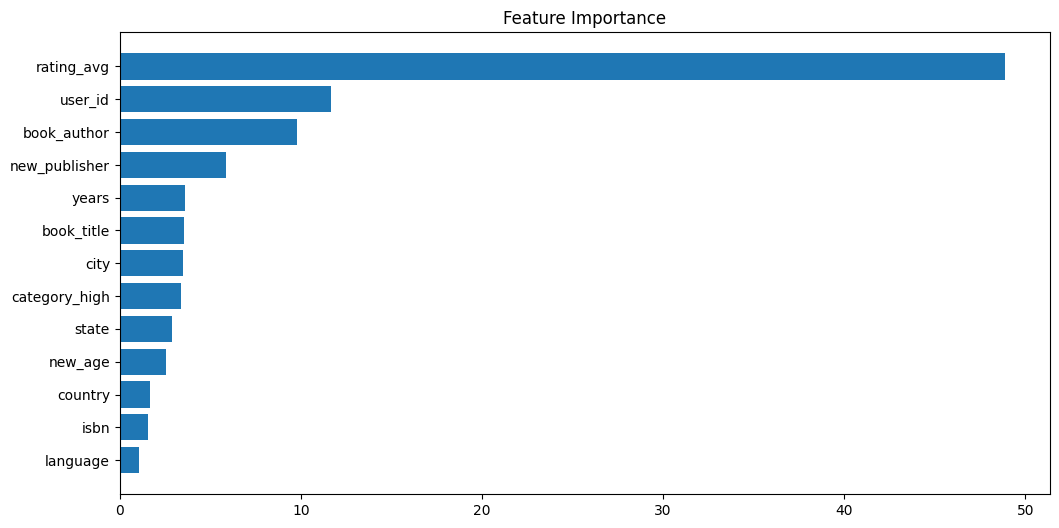

In [47]:
feature_importance = cat_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize = (12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align = 'center')
plt.yticks(range(len(sorted_idx)), np.array(X_data.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [49]:
test_ratings['rating'] = (pred_df['pred_0'] + pred_df['pred_1'] + pred_df['pred_2'] + pred_df['pred_3'] + pred_df['pred_4'] + 
                     pred_df['pred_5'] + pred_df['pred_6'] + pred_df['pred_7'] + pred_df['pred_8'] + pred_df['pred_9']) / 10
submit = test_ratings[['user_id', 'isbn', 'rating']]
submit

,user_id,isbn,rating
0,11676,0002005018,7.066980
1,116866,0002005018,7.668482
2,152827,0060973129,8.320372
3,157969,0374157065,7.769433
4,67958,0399135782,8.436759
...,...,...,...
76694,278543,1576734218,6.505219
76695,278563,3492223710,6.650600
76696,278633,1896095186,6.597798
76697,278668,8408044079,2.813656


In [50]:
submit.to_csv('./code/submit/CB_HPO_Pred_AVG.csv', index = False)

In [52]:
submit['rating'] = submit['rating'].round().astype(int)
submit.to_csv('./code/submit/CB_HPO_Pred_AVG_round.csv', index = False)

- best_params = {'learning_rate': 0.1, 'depth': 10, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
    - LB : 2.2369 / CV : 1.7941

- best_params = {'learning_rate': 0.1, 'reg_lambda': 10, 'random_strength': 26, 'depth': 9, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3741523922560336}
    - LB : 2.2479 / CV : 1.7941

- best_params = {'depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'random_strength': 0.001, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.739458755076581} 
    - LB : 2.2444 / CV : 1.78230

- best_params = {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
    - LB : / CV : 1.76569 

## LightGBM

In [14]:
def objectiveLGBM(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'boosting_type' : trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves' : trial.suggest_int('num_leaves', 30, 50),
        'max_depth' : trial.suggest_int('max_depth', 1, 15),
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-5, 1e-3, 0.1, 0.5]),
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree', [0.1, 0.3, 0.5, 0.7, 1.0]),
        'subsample' : trial.suggest_categorical('subsample', [0.1, 0.3, 0.5, 0.7, 1.0]),
        'reg_alpha' : trial.suggest_categorical('reg_alpha', [1e-3, 0.1, 1, 5, 10]),
        'reg_lambda' : trial.suggest_categorical('reg_lambda', [1e-3, 0.1, 1, 5, 10]),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [1e-3, 0.1, 1, 5, 10]),
    }
    lgbm_model = LGBMRegressor(**param, n_estimators = 5000, objective = 'regression', metric = 'rmse',
                               n_jobs = -1, verbose = -1, random_state = SEED)
    callback = lightgbm.early_stopping(stopping_rounds = 100)
    lgbm_model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
                   eval_metric = 'rmse', callbacks = [callback])
    
    score = mean_squared_error(y_valid, lgbm_model.predict(X_valid), squared = False)
    return score

In [15]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objectiveLGBM(trial, X_train, y_train, X_valid, y_valid), n_trials = 50)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n') 

[I 2023-12-15 13:08:07,509] A new study created in memory with name: no-name-2b5465e9-b405-46d5-8a39-a72bff979798
[I 2023-12-15 13:13:22,558] Trial 0 finished with value: 1.9462932670262931 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'max_depth': 9, 'learning_rate': 0.5, 'colsample_bytree': 0.7, 'subsample': 1.0, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 0 with value: 1.9462932670262931.
[I 2023-12-15 13:23:04,161] Trial 1 finished with value: 2.7512655857240094 and parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'max_depth': 5, 'learning_rate': 0.001, 'colsample_bytree': 0.5, 'subsample': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 10, 'min_child_weight': 0.1}. Best is trial 0 with value: 1.9462932670262931.
[I 2023-12-15 13:27:42,611] Trial 2 finished with value: 7.630890264743444 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 15, 'learning_rate': 0.5, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 10, '

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 2.12043	valid_1's rmse: 2.1288


[I 2023-12-15 13:28:02,097] Trial 3 finished with value: 2.1288043693622063 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'max_depth': 5, 'learning_rate': 0.001, 'colsample_bytree': 0.1, 'subsample': 0.1, 'reg_alpha': 10, 'reg_lambda': 10, 'min_child_weight': 0.001}. Best is trial 0 with value: 1.9462932670262931.
[I 2023-12-15 13:31:12,186] Trial 4 finished with value: 7.395880250694369 and parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'max_depth': 5, 'learning_rate': 0.5, 'colsample_bytree': 0.1, 'subsample': 0.3, 'reg_alpha': 10, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 0 with value: 1.9462932670262931.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 1.89957	valid_1's rmse: 1.9121


[I 2023-12-15 13:31:24,501] Trial 5 finished with value: 1.912103023622258 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': 1, 'learning_rate': 0.001, 'colsample_bytree': 0.7, 'subsample': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 10, 'min_child_weight': 10}. Best is trial 5 with value: 1.912103023622258.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 1.91529	valid_1's rmse: 1.92689


[I 2023-12-15 13:31:37,414] Trial 6 finished with value: 1.9268898092436648 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'max_depth': 2, 'learning_rate': 0.001, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 5, 'reg_lambda': 0.001, 'min_child_weight': 0.001}. Best is trial 5 with value: 1.912103023622258.
[I 2023-12-15 13:37:40,556] Trial 7 finished with value: 7.040715559633694 and parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'max_depth': 3, 'learning_rate': 1e-05, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 5 with value: 1.912103023622258.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:37:41,548] Trial 8 finished with value: 1.8746150189688395 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 11, 'learning_rate': 0.5, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 0.001}. Best is trial 8 with value: 1.8746150189688395.


Early stopping, best iteration is:
[60]	training's rmse: 1.82236	valid_1's rmse: 1.87462


[I 2023-12-15 13:39:44,804] Trial 9 finished with value: 7.143864739495544 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 1, 'learning_rate': 0.5, 'colsample_bytree': 0.1, 'subsample': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 10, 'min_child_weight': 0.001}. Best is trial 8 with value: 1.8746150189688395.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[723]	training's rmse: 1.77405	valid_1's rmse: 1.85849


[I 2023-12-15 13:39:48,696] Trial 10 finished with value: 1.8584892610762904 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 10 with value: 1.8584892610762904.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[723]	training's rmse: 1.77405	valid_1's rmse: 1.85849


[I 2023-12-15 13:39:52,377] Trial 11 finished with value: 1.8584892610762904 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 10 with value: 1.8584892610762904.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:39:55,595] Trial 12 finished with value: 1.857775242096866 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[552]	training's rmse: 1.7623	valid_1's rmse: 1.85778
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:39:58,378] Trial 13 finished with value: 1.8585193975128478 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[425]	training's rmse: 1.77931	valid_1's rmse: 1.85852
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:40:01,583] Trial 14 finished with value: 1.857775242096866 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[552]	training's rmse: 1.7623	valid_1's rmse: 1.85778
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:40:04,694] Trial 15 finished with value: 1.8589018676501479 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[528]	training's rmse: 1.7728	valid_1's rmse: 1.8589
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:40:07,616] Trial 16 finished with value: 1.8577964842982615 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[423]	training's rmse: 1.77454	valid_1's rmse: 1.8578
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 2.38464	valid_1's rmse: 2.38748


[I 2023-12-15 13:40:54,741] Trial 17 finished with value: 2.387477835090298 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'max_depth': 10, 'learning_rate': 1e-05, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.001, 'min_child_weight': 0.1}. Best is trial 12 with value: 1.857775242096866.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:40:57,363] Trial 18 finished with value: 1.8587716897589244 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 14, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 5, 'min_child_weight': 10}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[377]	training's rmse: 1.7925	valid_1's rmse: 1.85877
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:41:01,099] Trial 19 finished with value: 1.8582821669272167 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[573]	training's rmse: 1.76466	valid_1's rmse: 1.85828
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:41:04,206] Trial 20 finished with value: 1.8588447516713684 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 1.0, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[539]	training's rmse: 1.78037	valid_1's rmse: 1.85884
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:41:07,260] Trial 21 finished with value: 1.8587113110373277 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[518]	training's rmse: 1.76278	valid_1's rmse: 1.85871
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:41:11,075] Trial 22 finished with value: 1.8575745931789833 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 22 with value: 1.8575745931789833.


Early stopping, best iteration is:
[650]	training's rmse: 1.73984	valid_1's rmse: 1.85757
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:41:14,329] Trial 23 finished with value: 1.85818538329485 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 11, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 22 with value: 1.8575745931789833.


Early stopping, best iteration is:
[522]	training's rmse: 1.75685	valid_1's rmse: 1.85819
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 2.38463	valid_1's rmse: 2.38747


[I 2023-12-15 13:42:01,821] Trial 24 finished with value: 2.3874743996148307 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 13, 'learning_rate': 1e-05, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 22 with value: 1.8575745931789833.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:42:04,560] Trial 25 finished with value: 1.8585842402412496 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 14, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.1, 'reg_alpha': 5, 'reg_lambda': 0.001, 'min_child_weight': 10}. Best is trial 22 with value: 1.8575745931789833.


Early stopping, best iteration is:
[409]	training's rmse: 1.78549	valid_1's rmse: 1.85858
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:42:08,033] Trial 26 finished with value: 1.8584412191840736 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 11, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 0.1}. Best is trial 22 with value: 1.8575745931789833.


Early stopping, best iteration is:
[524]	training's rmse: 1.75144	valid_1's rmse: 1.85844
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:42:10,480] Trial 27 finished with value: 1.8600474860038052 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'max_depth': 14, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 22 with value: 1.8575745931789833.


Early stopping, best iteration is:
[350]	training's rmse: 1.78709	valid_1's rmse: 1.86005
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:42:14,359] Trial 28 finished with value: 1.8574871315861985 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[736]	training's rmse: 1.76218	valid_1's rmse: 1.85749


[I 2023-12-15 13:52:56,996] Trial 29 finished with value: 7.039681670015834 and parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'max_depth': 10, 'learning_rate': 1e-05, 'colsample_bytree': 0.7, 'subsample': 1.0, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:53:00,438] Trial 30 finished with value: 1.8585056496616352 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[577]	training's rmse: 1.77664	valid_1's rmse: 1.85851
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:53:03,316] Trial 31 finished with value: 1.8587658341672764 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[460]	training's rmse: 1.78252	valid_1's rmse: 1.85877
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:53:06,052] Trial 32 finished with value: 1.8582679416830166 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[474]	training's rmse: 1.78822	valid_1's rmse: 1.85827
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:53:09,461] Trial 33 finished with value: 1.8582230064307186 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'subsample': 1.0, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 0.1}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[505]	training's rmse: 1.76928	valid_1's rmse: 1.85822


[I 2023-12-15 14:04:53,433] Trial 34 finished with value: 2.6918320047613067 and parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'max_depth': 10, 'learning_rate': 0.001, 'colsample_bytree': 1.0, 'subsample': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[755]	training's rmse: 1.8458	valid_1's rmse: 1.8692


[I 2023-12-15 14:04:57,793] Trial 35 finished with value: 1.869200286893409 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.1, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.
[I 2023-12-15 14:09:39,168] Trial 36 finished with value: 6.48642594539177 and parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'max_depth': 14, 'learning_rate': 0.5, 'colsample_bytree': 0.5, 'subsample': 0.1, 'reg_alpha': 10, 'reg_lambda': 10, 'min_child_weight': 1}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 1.84985	valid_1's rmse: 1.87116


[I 2023-12-15 14:10:17,376] Trial 37 finished with value: 1.871155010870594 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 7, 'learning_rate': 0.001, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.001, 'min_child_weight': 10}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[786]	training's rmse: 1.75786	valid_1's rmse: 1.85858


[I 2023-12-15 14:10:21,593] Trial 38 finished with value: 1.858578974238592 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.3, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.
[I 2023-12-15 14:19:13,978] Trial 39 finished with value: 5.036427020323276 and parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 11, 'learning_rate': 0.5, 'colsample_bytree': 0.1, 'subsample': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 1.86132	valid_1's rmse: 1.8763


[I 2023-12-15 14:19:38,249] Trial 40 finished with value: 1.8763005927508853 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'max_depth': 4, 'learning_rate': 0.001, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 10, 'reg_lambda': 10, 'min_child_weight': 0.001}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 14:19:42,482] Trial 41 finished with value: 1.857660253962212 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[697]	training's rmse: 1.73274	valid_1's rmse: 1.85766
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 14:19:47,268] Trial 42 finished with value: 1.8570557359879565 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 42 with value: 1.8570557359879565.


Early stopping, best iteration is:
[728]	training's rmse: 1.72591	valid_1's rmse: 1.85706
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 14:19:50,756] Trial 43 finished with value: 1.8584288407622231 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 42 with value: 1.8570557359879565.


Early stopping, best iteration is:
[527]	training's rmse: 1.7551	valid_1's rmse: 1.85843
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[737]	training's rmse: 1.76437	valid_1's rmse: 1.85693


[I 2023-12-15 14:19:54,867] Trial 44 finished with value: 1.8569333368094627 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[737]	training's rmse: 1.76437	valid_1's rmse: 1.85693


[I 2023-12-15 14:19:59,063] Trial 45 finished with value: 1.8569333368094627 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 2.41605	valid_1's rmse: 2.41838


[I 2023-12-15 14:20:34,207] Trial 46 finished with value: 2.418384658168914 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 12, 'learning_rate': 1e-05, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[623]	training's rmse: 1.77565	valid_1's rmse: 1.85765


[I 2023-12-15 14:20:37,907] Trial 47 finished with value: 1.8576454680744567 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 11, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.
[I 2023-12-15 14:25:54,759] Trial 48 finished with value: 6.307307968382457 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'max_depth': 10, 'learning_rate': 0.5, 'colsample_bytree': 0.3, 'subsample': 1.0, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 14:25:58,069] Trial 49 finished with value: 1.8577011339968028 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.


Early stopping, best iteration is:
[517]	training's rmse: 1.78368	valid_1's rmse: 1.8577
Best trial : score 1.8569333368094627, 
 params = {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1} 



In [16]:
X_data, y_data = train_GB.drop(columns = 'rating'), train_GB['rating']

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
valid_rmse = []
pred_df = pd.DataFrame()

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) :
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    # Best Parameter 학습
    param = study.best_params # lgbm_best_params
    
    lgbm_reg = LGBMRegressor(**param, n_estimators = 5000, objective = 'regression', metric = 'rmse',
                             n_jobs = -1, verbose = -1, random_state = SEED)
    callback = lightgbm.early_stopping(stopping_rounds = 100)
    lgbm_reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
                   eval_metric = 'rmse', callbacks = [callback])
    
    # 모델 RMSE 출력
    score = mean_squared_error(y_valid, lgbm_reg.predict(X_valid), squared = False)
    valid_rmse.append(score)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {score:.5f}')

    # Predict
    pred = lgbm_reg.predict(test_GB.drop(['rating'], axis = 1))
    pred_df[f'pred_{fold}'] = pred

print(f'LGBM RMSE 평균 : {np.array(valid_rmse).mean():.5f} \n')

  0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[669]	training's rmse: 1.77124	valid_1's rmse: 1.84505
Valid Set 1 번째 Fold RMSE : 1.84505


 10%|█         | 1/10 [00:04<00:39,  4.36s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[709]	training's rmse: 1.76938	valid_1's rmse: 1.84211
Valid Set 2 번째 Fold RMSE : 1.84211


 20%|██        | 2/10 [00:08<00:35,  4.46s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[750]	training's rmse: 1.76591	valid_1's rmse: 1.83455
Valid Set 3 번째 Fold RMSE : 1.83455


 30%|███       | 3/10 [00:13<00:32,  4.58s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[723]	training's rmse: 1.76602	valid_1's rmse: 1.84613
Valid Set 4 번째 Fold RMSE : 1.84613


 40%|████      | 4/10 [00:17<00:26,  4.46s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[955]	training's rmse: 1.74373	valid_1's rmse: 1.84995
Valid Set 5 번째 Fold RMSE : 1.84995


 50%|█████     | 5/10 [00:23<00:24,  4.96s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[919]	training's rmse: 1.74868	valid_1's rmse: 1.85163
Valid Set 6 번째 Fold RMSE : 1.85163


 60%|██████    | 6/10 [00:29<00:20,  5.22s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[691]	training's rmse: 1.76928	valid_1's rmse: 1.84911
Valid Set 7 번째 Fold RMSE : 1.84911


 70%|███████   | 7/10 [00:33<00:14,  4.92s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[877]	training's rmse: 1.75255	valid_1's rmse: 1.85598
Valid Set 8 번째 Fold RMSE : 1.85598


 80%|████████  | 8/10 [00:39<00:10,  5.08s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[813]	training's rmse: 1.76037	valid_1's rmse: 1.84043
Valid Set 9 번째 Fold RMSE : 1.84043


 90%|█████████ | 9/10 [00:44<00:05,  5.06s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[651]	training's rmse: 1.77385	valid_1's rmse: 1.85223
Valid Set 10 번째 Fold RMSE : 1.85223


100%|██████████| 10/10 [00:48<00:00,  4.83s/it]

LGBM RMSE 평균 : 1.84672 



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

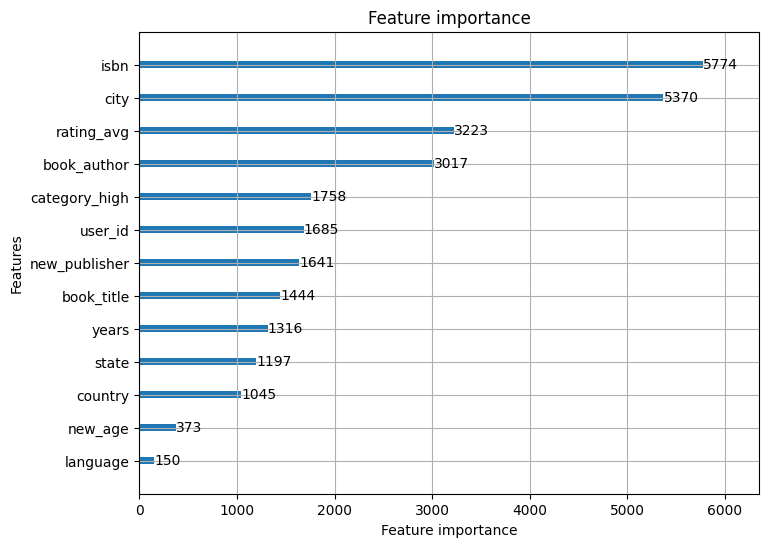

In [17]:
# Feature Importance
fig, ax = plt.subplots(figsize = (8, 6))
lgbm_plot_importance(lgbm_reg, ax = ax)

In [18]:
test_ratings['rating'] = (pred_df['pred_0'] + pred_df['pred_1'] + pred_df['pred_2'] + pred_df['pred_3'] + pred_df['pred_4'] + 
                          pred_df['pred_5'] + pred_df['pred_6'] + pred_df['pred_7'] + pred_df['pred_8'] + pred_df['pred_9']) / 10
submit = test_ratings[['user_id', 'isbn', 'rating']]
submit

,user_id,isbn,rating
0,11676,0002005018,6.949023
1,116866,0002005018,7.718842
2,152827,0060973129,8.618080
3,157969,0374157065,7.926602
4,67958,0399135782,8.120157
...,...,...,...
76694,278543,1576734218,6.351776
76695,278563,3492223710,7.332121
76696,278633,1896095186,7.038254
76697,278668,8408044079,3.432230


In [19]:
submit.to_csv('./code/submit/LGBM_HPO_Pred_AVG.csv', index = False)

In [20]:
submit['rating'] = submit['rating'].round().astype(int)
submit.to_csv('./code/submit/LGBM_HPO_Pred_AVG_round.csv', index = False)

- {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': 3, 'learning_rate': 0.5, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 1}
    - LB : 2.2771 / CV : 1.85789

## XGBoost

In [18]:
def objectiveXGB(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'booster' : trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'max_depth' : trial.suggest_int('max_depth', 1, 15),
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.05, 0.1, 0.5]), # 1e-5,
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
        'gamma' : trial.suggest_categorical('alpha', [1e-5, 1e-3, 1, 5, 10]),
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree', [0.1, 0.5, 1]),
        'lambda' : trial.suggest_categorical('lambda', [1e-5, 1e-3, 1, 5, 10]),
        'alpha' : trial.suggest_categorical('alpha', [1e-5, 1e-3, 1, 5, 10]),
        'subsample' : trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'max_delta_step' : trial.suggest_categorical('max_delta_step', [0.1, 0.5, 1, 5, 10]),
    }
    
    # XGBRegressor 사용
    model = XGBRegressor(**param, n_estimators = 5000, objective = 'reg:squarederror', eval_metric = 'rmse',
                         nthread = -1, gpu_id = 0, tree_method = 'gpu_hist', predictor = 'gpu_predictor',
                         early_stopping_rounds = 100, random_state = SEED)
    xgb_model = model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = 300)
    
    # Valid Set RMSE 계산
    score = mean_squared_error(y_valid, xgb_model.predict(X_valid), squared = False)
    return score

In [19]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objectiveXGB(trial, X_train, y_train, X_valid, y_valid), n_trials = 50)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

[I 2023-12-16 02:39:55,880] A new study created in memory with name: no-name-2467daf9-4961-47e2-a2f4-d566c45aeef2


[0]	validation_0-rmse:2.00523	validation_1-rmse:2.03346
[105]	validation_0-rmse:1.38723	validation_1-rmse:1.95045


[I 2023-12-16 02:40:02,689] Trial 0 finished with value: 1.887207962657868 and parameters: {'booster': 'dart', 'max_depth': 11, 'learning_rate': 0.5, 'min_child_weight': 7, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 5, 'subsample': 1.0, 'max_delta_step': 10}. Best is trial 0 with value: 1.887207962657868.


[0]	validation_0-rmse:2.43202	validation_1-rmse:2.43406
[300]	validation_0-rmse:2.40486	validation_1-rmse:2.40755
[600]	validation_0-rmse:2.37566	validation_1-rmse:2.37906
[900]	validation_0-rmse:2.34489	validation_1-rmse:2.34903
[1200]	validation_0-rmse:2.31603	validation_1-rmse:2.32088
[1500]	validation_0-rmse:2.29553	validation_1-rmse:2.30102
[1800]	validation_0-rmse:2.27405	validation_1-rmse:2.28017
[2100]	validation_0-rmse:2.24965	validation_1-rmse:2.25647
[2400]	validation_0-rmse:2.23270	validation_1-rmse:2.24004
[2700]	validation_0-rmse:2.21629	validation_1-rmse:2.22413
[3000]	validation_0-rmse:2.20240	validation_1-rmse:2.21075
[3300]	validation_0-rmse:2.18910	validation_1-rmse:2.19790
[3600]	validation_0-rmse:2.17755	validation_1-rmse:2.18678
[3900]	validation_0-rmse:2.16438	validation_1-rmse:2.17405
[4200]	validation_0-rmse:2.15394	validation_1-rmse:2.16399
[4500]	validation_0-rmse:2.13821	validation_1-rmse:2.14877
[4800]	validation_0-rmse:2.12192	validation_1-rmse:2.13298
[49

[I 2023-12-16 02:40:29,997] Trial 1 finished with value: 2.1257598934600197 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.001, 'min_child_weight': 5, 'alpha': 5, 'colsample_bytree': 0.1, 'lambda': 1, 'subsample': 0.8, 'max_delta_step': 5}. Best is trial 0 with value: 1.887207962657868.


[0]	validation_0-rmse:2.40945	validation_1-rmse:2.41180
[300]	validation_0-rmse:2.02143	validation_1-rmse:2.03950
[600]	validation_0-rmse:1.88665	validation_1-rmse:1.90704
[900]	validation_0-rmse:1.85113	validation_1-rmse:1.87454
[1200]	validation_0-rmse:1.84652	validation_1-rmse:1.87085
[1322]	validation_0-rmse:1.84637	validation_1-rmse:1.87082


[I 2023-12-16 02:40:34,130] Trial 2 finished with value: 1.8705904401754743 and parameters: {'booster': 'gbtree', 'max_depth': 5, 'learning_rate': 0.5, 'min_child_weight': 8, 'alpha': 1, 'colsample_bytree': 0.1, 'lambda': 0.001, 'subsample': 0.8, 'max_delta_step': 0.1}. Best is trial 2 with value: 1.8705904401754743.


[0]	validation_0-rmse:2.43257	validation_1-rmse:2.43460
[300]	validation_0-rmse:2.41860	validation_1-rmse:2.42100
[600]	validation_0-rmse:2.40350	validation_1-rmse:2.40629
[900]	validation_0-rmse:2.38703	validation_1-rmse:2.39023
[1200]	validation_0-rmse:2.37125	validation_1-rmse:2.37483
[1500]	validation_0-rmse:2.35926	validation_1-rmse:2.36321
[1800]	validation_0-rmse:2.34674	validation_1-rmse:2.35102
[2100]	validation_0-rmse:2.33232	validation_1-rmse:2.33697
[2400]	validation_0-rmse:2.32172	validation_1-rmse:2.32665


In [ ]:
X_data, y_data = train_GB.drop(columns = 'rating'), train_GB['rating']

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
valid_rmse = []
pred_df = pd.DataFrame()

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) :
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    # Best Parameter 학습
    param = study.best_params # xgb_best_params
    
    # Best Parameter 학습
    xgb_reg = XGBRegressor(**param, n_estimators = 5000, objective = 'reg:squarederror', eval_metric = 'rmse', 
                           nthread = -1, gpu_id = 0, tree_method = 'gpu_hist', predictor = 'gpu_predictor',
                           early_stopping_rounds = 100, random_state = SEED)
    xgb_reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = False)
    
    # 모델 RMSE 출력
    score = mean_squared_error(y_valid, xgb_reg.predict(X_valid), squared = False)
    valid_rmse.append(score)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {score:.5f}')
    
    # Predict
    pred = xgb_reg.predict(test_GB.drop(['rating'], axis = 1))
    pred_df[f'pred_{fold}'] = pred

print(f'XGBoost RMSE 평균 : {np.array(valid_rmse).mean():.5f} \n')

 10%|█         | 1/10 [07:27<1:07:10, 447.87s/it]

Valid Set 1 번째 Fold RMSE : 1.85683


 20%|██        | 2/10 [14:43<58:46, 440.80s/it]  

Valid Set 2 번째 Fold RMSE : 1.85320


 30%|███       | 3/10 [22:06<51:30, 441.50s/it]

Valid Set 3 번째 Fold RMSE : 1.84803


 40%|████      | 4/10 [29:07<43:22, 433.73s/it]

Valid Set 4 번째 Fold RMSE : 1.85734


 50%|█████     | 5/10 [36:33<36:29, 437.86s/it]

Valid Set 5 번째 Fold RMSE : 1.86337


 60%|██████    | 6/10 [43:45<29:04, 436.14s/it]

Valid Set 6 번째 Fold RMSE : 1.86145


 70%|███████   | 7/10 [50:33<21:20, 426.67s/it]

Valid Set 7 번째 Fold RMSE : 1.86348


 80%|████████  | 8/10 [57:53<14:22, 431.13s/it]

Valid Set 8 번째 Fold RMSE : 1.86570


 90%|█████████ | 9/10 [1:05:10<07:12, 432.80s/it]

Valid Set 9 번째 Fold RMSE : 1.85662


100%|██████████| 10/10 [1:12:25<00:00, 434.53s/it]

Valid Set 10 번째 Fold RMSE : 1.86556
XGBoost RMSE 평균 : 1.85916 



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

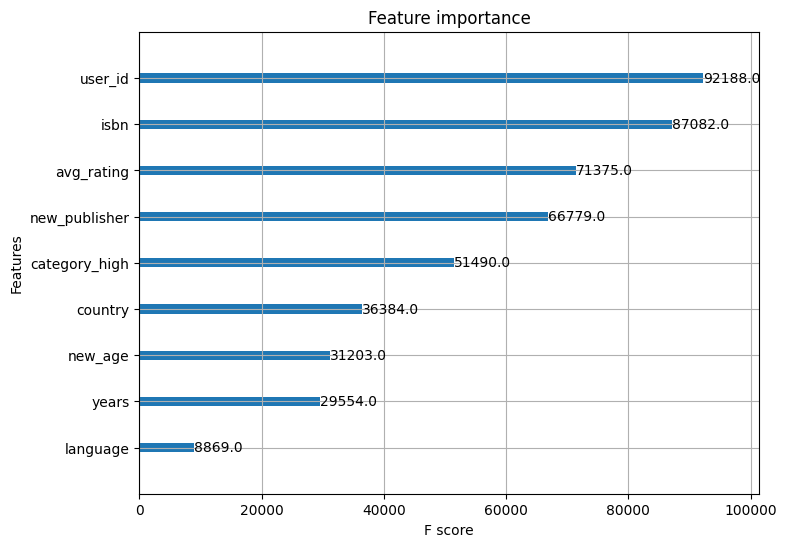

In [ ]:
# Feature Importance
fig, ax = plt.subplots(figsize = (8, 6))
xgb_plot_importance(xgb_reg, ax = ax)

In [ ]:
test_ratings['rating'] = (pred_df['pred_0'] + pred_df['pred_1'] + pred_df['pred_2'] + pred_df['pred_3'] + pred_df['pred_4'] + 
                          pred_df['pred_5'] + pred_df['pred_6'] + pred_df['pred_7'] + pred_df['pred_8'] + pred_df['pred_9']) / 10
submit = test_ratings[['user_id', 'isbn', 'rating']]
submit

,user_id,isbn,rating
0,11676,0002005018,7.066980
1,116866,0002005018,7.668482
2,152827,0060973129,8.320372
3,157969,0374157065,7.769433
4,67958,0399135782,8.436759
...,...,...,...
76694,278543,1576734218,6.505219
76695,278563,3492223710,6.650600
76696,278633,1896095186,6.597798
76697,278668,8408044079,2.813656


In [ ]:
submit.to_csv('./code/submit/XGB_HPO_Pred_AVG.csv', index = False)

In [ ]:
submit['rating'] = submit['rating'].round().astype(int)
submit.to_csv('./code/submit/XGB_HPO_Pred_AVG_round.csv', index = False)

# Ensemble

In [51]:
os.listdir('./code/submit/')

['20231214_141423_DeepCoNN.csv',
 'Catboost_Optuna_withGPU_fold10.csv',
 '20231215_031836_DCN.csv',
 '20231212_225413_FM.csv',
 'Catboost_Optuna_fold10_loc_round.csv',
 'XGBoost_Optuna_withGPU_fold10.csv',
 '20231215_080141_DCN.csv',
 '20231215_075938_DCN.csv',
 'LGBM_Optuna_withGPU_fold10.csv',
 'Catboost_Optuna_withGPU.csv',
 'Catboost_Optuna.csv',
 'Catboost_Optuna_fold10_loc.csv',
 '20231215_082021_DCN.csv',
 '20231215_062520_DCN.csv']